In [1]:
from copy import deepcopy
import os
import sys
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd

from scipy.optimize import basinhopping, minimize
from scipy.stats import chisquare

sys.path.append(os.path.dirname(sys.path[0]))

In [3]:
import scripts.constants as con
from scripts.helpers import get_unique_frame
from scripts.pca import PCA
from scripts.plotter import Plotter, get_temperature_legend
from scripts.properties.ovito_procedures import OvitoProcessor
from scripts.rdf_calculator import RDFCalculator

In [4]:
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.figsize'] = [i / 2.54 for i in (15, 15)]
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.it'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.labelsize'] = 14

In [5]:
np.random.seed(0)

In [6]:
@njit
def math_round(value):
    rest = value - int(value)
    if rest >= 0.5 and value >= 0:
        return float(int(value) + 1)
    if rest <= -0.5 and value < 0:
        return float(int(value) - 1)
    return float(int(value))

@njit
def get_boundary_conditions(
        cell_dimensions: np.ndarray,
        particles_number: int,
        positions: np.ndarray,
):
    for i in range(particles_number):
        for j in range(3):
            if positions[i][j] >= cell_dimensions[j] / 2.0:
                positions[i][j] -= (
                        math_round(positions[i][j] / cell_dimensions[j])
                        * cell_dimensions[j]
                )
            if positions[i][j] < -cell_dimensions[j] / 2.0:
                positions[i][j] -= (
                        math_round(positions[i][j] / cell_dimensions[j])
                        * cell_dimensions[j]
                )
    return positions

In [7]:
def calculate_rdf(positions):
    cell_dimensions = np.array([12.25, 12.25, 12.25])
    radii, rdf = OvitoProcessor(
        positions=positions, 
        cell_dimensions=cell_dimensions,
    ).get_rdf()
    return radii, rdf

In [8]:
def mse(obs, exp):
    return np.sum((obs - exp) ** 2)

In [9]:
def generate_random_state() -> None:
    particles_number = 1372
    cell_dimensions = 12.25 * np.ones(3)
    return (np.random.random((particles_number, 3)) - 0.5) * cell_dimensions

In [10]:
CURRENT_DATA_NORMAL = '2021-09-24_prepared_1.3_normal'
PLOT_FILENAME_POSTFIX_NORMAL = 'hooke_jeeves_minimization_global'

PATH_TO_CURRENT_DATA_NORMAL = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_NORMAL)
PATH_TO_PLOTS = os.path.join(con.PATH_TO_PLOTS, CURRENT_DATA_NORMAL)
PATH_TO_CURRENT_DATA_NORMAL

'D:\\albert\\programming\\git_reps\\molecular_dynamics\\data\\2021-09-24_prepared_1.3_normal'

In [11]:
samples = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'samples.npy'))
test_sample = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'test_sample.npy'))
targets = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'targets_pbc.npy'))
cooled_1 = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'cooled_1.npy'))
cooled_2 = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'cooled_2.npy'))

samples.shape, test_sample.shape, targets.shape, cooled_1.shape, cooled_2.shape

((2464, 612), (1, 612), (2464, 1372, 3), (1372, 3), (1372, 3))

In [12]:
i = 1
obs_rdf = samples[i]
some_positions = generate_random_state()
some_positions.shape

(1372, 3)

$$G = \int_0^1{g(r)dr}$$

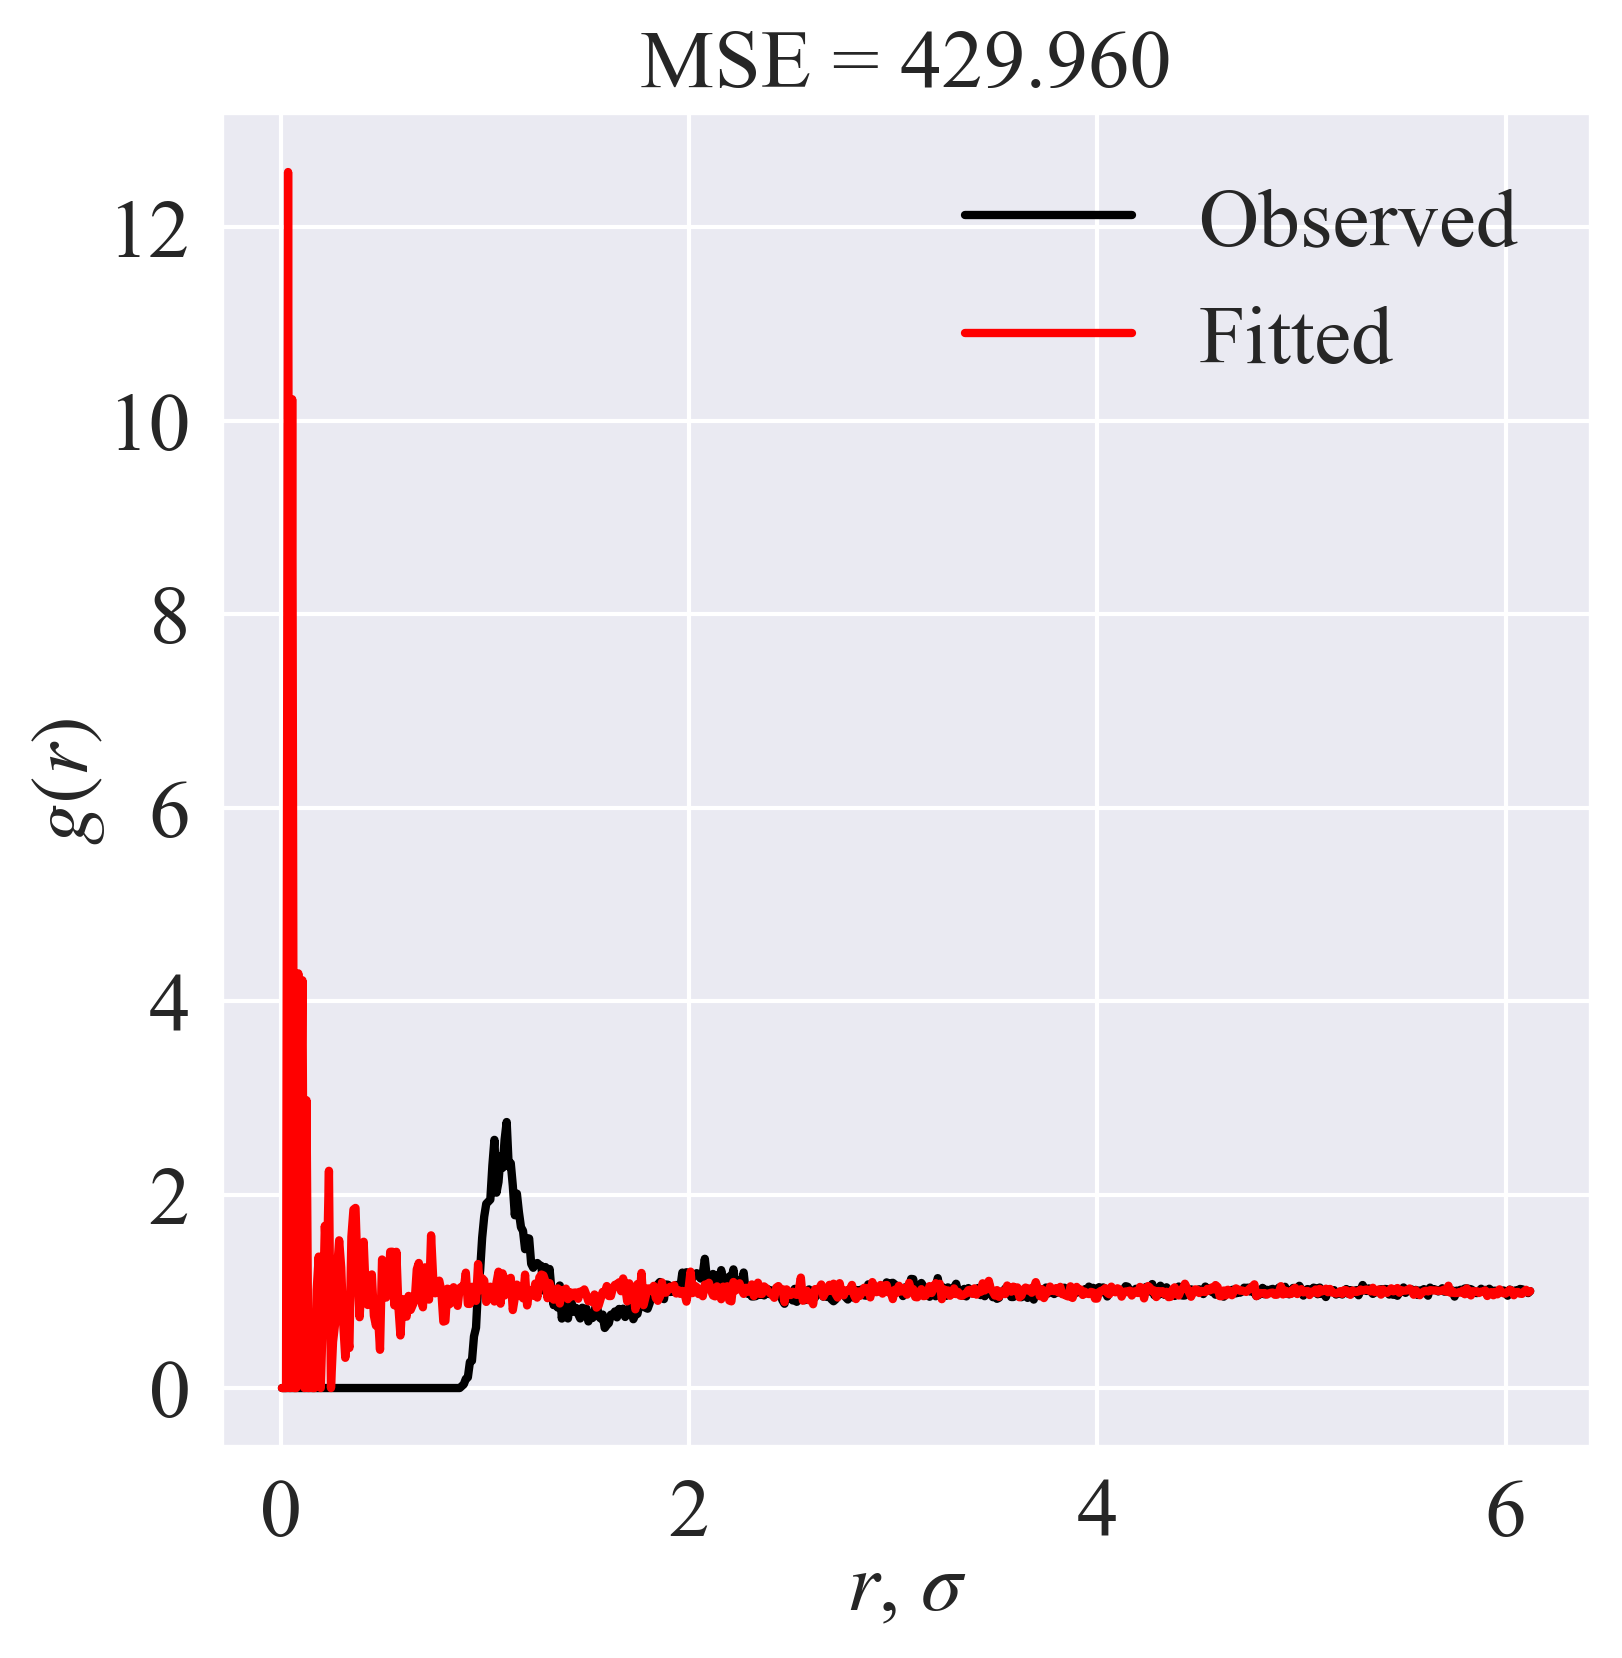

In [13]:
radii, exp_rdf = calculate_rdf(some_positions)
size = obs_rdf.size
radii = radii[:size]
exp_rdf = exp_rdf[:size]

plotter = Plotter(
    path_to_plots=PATH_TO_PLOTS,
    labels=('radius', 'rdf'),
)
plotter.ax.plot(radii, obs_rdf, color='black', label='Observed')
plotter.ax.plot(radii, exp_rdf, color='red', label='Fitted')
plotter.set_title(f'MSE = {mse(obs=obs_rdf, exp=exp_rdf):.3f}')
plotter.get_legend()
plotter.save_plot('initial_state.png')
plt.show()

In [14]:
cell_dimensions = np.ones(3) * 12.25

In [15]:
def optimized_func(positions):
    collided_number = 0
    positions = positions.reshape(1372, 3)
    radii, exp_rdf = calculate_rdf(positions)
    size = obs_rdf.size
    radii = radii[:size]
    exp_rdf = exp_rdf[:size]
    if np.where(exp_rdf > 0)[0][0] < np.where(obs_rdf > 0)[0][0]:
        collided_number = exp_rdf[np.where(exp_rdf > 0)[0]].sum()
    result = mse(obs=obs_rdf, exp=exp_rdf)
    return result, collided_number

In [16]:
def hooke_jeeves_minimization(
        optimized,
        function: callable,
        accuracy,
        step: float,
):
    old_result = function(optimized)
    new_result = np.array(old_result)
    mse_values = [old_result[0]]
    parameters_array = [np.array(optimized)]
    outer_step_number = 1
    while step > accuracy:
        inner_start = datetime.now()
        print(f'{outer_step_number = }')
        print(f'{step = }')
        x_old = np.array(optimized)
        for i in range(optimized.shape[0]):
            if i % 400 == 0:
                print(f'{i}/{optimized.shape[0]} particles are processed at step {outer_step_number}...')
                
            for j in range(optimized.shape[1]):
                _steps = np.zeros(optimized.shape)
                _steps[i][j] += step
                new_result = function(optimized + _steps)
                if (new_result < old_result).all():
                    optimized += _steps
                    old_result = np.array(new_result)
                else:
                    new_result = function(optimized - _steps)
                    if (new_result < old_result).all():
                        optimized -= _steps
                        old_result = np.array(new_result)
                    else:
                        new_result = np.array(old_result)

        x_new = np.array(optimized)
        optimized = x_old + 2 * (x_new - x_old)
        old_result = function(optimized)
        if old_result[0] >= new_result[0]:
            optimized = np.array(x_new)
            old_result = np.array(new_result)
            step = step / 5
        outer_step_number += 1
        mse_values.append(old_result[0])
        parameters_array.append(np.array(optimized))
        print(f'Current MSE = {old_result[0]}')
        if len(mse_values) > 2 and mse_values[-1] == mse_values[-2]:
            break
        print('HJ step execution time:', datetime.now() - inner_start)
    return optimized, mse_values, parameters_array

In [17]:
def interruption_proof_minimization(minimization_method, args, **kwargs):
    outer_start = datetime.now()
    optimized = np.array(args)
    try:
        optimized, mse_values, parameters_array = minimization_method(optimized, **kwargs)
    except (KeyboardInterrupt, SystemError):
        pass
    print(mse_values)
    print('Local minimization time:', datetime.now() - outer_start)
    return optimized, mse_values, parameters_array

In [18]:
def global_minimization():
    global_start = datetime.now()
    local_minima = []
    global_minimum = float('inf')
    global_index = None
    i = 0
    is_global = False
    while not is_global:
        print(f'*************Step {i + 1}*************')
        
        initial_config = PCA(
            iterations_number=100,
            fitness=lambda x: optimized_func(x)[0] + optimized_func(x)[1],
            parameters_number=1372*3,
            bounds=(-6.125, 6.125),
        ).run_pca().reshape(1372, 3)
        is_global = True
        
        optimized, mse_values, parameters_array = interruption_proof_minimization(
            minimization_method=hooke_jeeves_minimization,
#             args=generate_random_state(),
            args=initial_config,
            function=optimized_func,
            accuracy=1e-3,
            step=1,
        )
        local_minima.append({
            'optimized': optimized, 
            'mse_values': mse_values, 
            'parameters_array': parameters_array
        })
        if mse_values[-1] < global_minimum:
            global_minimum = mse_values[-1]
            global_index = i
        if global_minimum < 1:
            is_global = True
        i += 1
    print('*************Final*************')
    optimized, mse_values, parameters_array = interruption_proof_minimization(
        minimization_method=hooke_jeeves_minimization,
        args=local_minima[global_index]['optimized'],
        function=optimized_func,
        accuracy=1e-7,
        step=1e-3,
    )
    print('Global minimization time:', datetime.now() - global_start)
    return optimized, mse_values, parameters_array

In [ ]:
new_positions, mse_values, parameters_array = global_minimization()

*************Step 1*************
Iteration 1 / 100.
Perturbation.
Scattering.
Exploration.
Iteration 2 / 100.
Perturbation.
Scattering.
Exploration.
Iteration 3 / 100.
Perturbation.
Scattering.
Iteration 4 / 100.
Perturbation.
Exploration.
Iteration 5 / 100.
Perturbation.
Scattering.
Iteration 6 / 100.
Perturbation.
Scattering.
Iteration 7 / 100.
Perturbation.
Scattering.
Iteration 8 / 100.
Perturbation.
Scattering.
Iteration 9 / 100.
Perturbation.
Scattering.
Iteration 10 / 100.
Perturbation.
Scattering.
Iteration 11 / 100.
Perturbation.
Scattering.
Iteration 12 / 100.
Perturbation.
Scattering.
Iteration 13 / 100.
Perturbation.
Scattering.
Iteration 14 / 100.
Perturbation.
Scattering.
Exploration.
Iteration 15 / 100.
Perturbation.
Scattering.
Iteration 16 / 100.
Perturbation.
Scattering.
Iteration 17 / 100.
Perturbation.
Exploration.
Iteration 18 / 100.
Perturbation.
Scattering.
Iteration 19 / 100.
Perturbation.
Scattering.
Iteration 20 / 100.
Perturbation.
Exploration.
Iteration 21 /

In [ ]:
radii, new_exp_rdf = calculate_rdf(new_positions)
size = obs_rdf.size
radii = radii[:size]
new_exp_rdf = new_exp_rdf[:size]

In [ ]:
mse_values

In [ ]:
print(f'Initial MSE = {mse(obs=obs_rdf, exp=exp_rdf)}')
print(f'Current MSE = {mse(obs=obs_rdf, exp=new_exp_rdf)}')

In [ ]:
plt.plot(radii, obs_rdf, color='black')
for i, parameters in enumerate(parameters_array):
    plt.plot(
        radii, 
        calculate_rdf(parameters)[1], 
        label=f'Step {i + 1}',
    )
plt.legend()
plt.show()

In [ ]:
radii, exp_rdf = calculate_rdf(new_positions)
size = obs_rdf.size
radii = radii[:size]
exp_rdf = exp_rdf[:size]

plotter = Plotter(
    path_to_plots=PATH_TO_PLOTS,
    labels=('radius', 'rdf'),
)
plotter.ax.plot(radii, obs_rdf, color='black', label='Observed')
plotter.ax.plot(radii, exp_rdf, color='red', label='Fitted')
plotter.set_title(f'MSE = {mse(obs=obs_rdf, exp=exp_rdf):.3f}')
plotter.get_legend()
plotter.save_plot('optimized_state_global.png')
plt.show()

In [ ]:
for i, parameters in enumerate(parameters_array):
    plt.plot(
        radii, 
        calculate_rdf(parameters)[1] - obs_rdf, 
        label=f'Step {i + 1}',
    )
plt.legend()
plt.show()

In [ ]:
some_positions

In [ ]:
new_positions

In [ ]:
cell_dimensions = np.ones(3) * 12.25
ovito_1 = OvitoProcessor(positions=some_positions, cell_dimensions=cell_dimensions)
ovito_2 = OvitoProcessor(positions=new_positions, cell_dimensions=cell_dimensions)

In [ ]:
indices_1 = get_unique_frame(ovito_1.get_voronoi_indices())
indices_2 = get_unique_frame(ovito_2.get_voronoi_indices())
for i in range(10):
    if i not in indices_1.columns:
        indices_1[i] = 0
    if i not in indices_2.columns:
        indices_2[i] = 0
merged_indices = indices_1.merge(
    right=indices_2, 
    on=list(range(10)), 
    how='outer',
).fillna(0).astype(int)
merged_indices['diff'] = merged_indices['counts_y'] - merged_indices['counts_x']
merged_indices

In [ ]:
volumes_1 = get_unique_frame(ovito_1.get_voronoi_volumes()).rename(columns={0: 'volume'})
volumes_2 = get_unique_frame(ovito_2.get_voronoi_volumes()).rename(columns={0: 'volume'})
merged_volumes = volumes_1.merge(
    right=volumes_2, 
    on='volume', 
    how='outer',
).fillna(0)
merged_volumes['diff'] = merged_volumes['counts_y'] - merged_volumes['counts_x']
merged_volumes

In [ ]:
coordinations_1 = get_unique_frame(ovito_1.get_voronoi_coordination()).rename(columns={0: 'coordination'})
coordinations_2 = get_unique_frame(ovito_2.get_voronoi_coordination()).rename(columns={0: 'coordination'})
merged_coordinations = coordinations_1.merge(
    right=coordinations_2, 
    on='coordination', 
    how='outer',
).fillna(0).astype(int)
merged_coordinations['diff'] = merged_coordinations['counts_y'] - merged_coordinations['counts_x']
merged_coordinations

In [ ]:
merged_indices = merged_indices[
    (merged_indices['counts_x'] > 1)
    & (merged_indices['counts_y'] > 1)
].reset_index(drop=True)
merged_indices

In [ ]:
merged_indices['diff'].describe()

In [ ]:
plt.bar(merged_coordinations['coordination'], merged_coordinations['counts_x'], alpha=0.5)
plt.bar(merged_coordinations['coordination'], merged_coordinations['counts_y'], alpha=0.5)
plt.show()

In [ ]:
hist, bins, _ = plt.hist(volumes_1['volume'], alpha=0.5)
plt.hist(volumes_2['volume'], alpha=0.5, bins=bins)
plt.show()

In [ ]:
radii, ovito_rdf_1, coordination_1 = ovito_1.get_rdf(is_coordination_returned=True)
radii, ovito_rdf_2, coordination_2 = ovito_2.get_rdf(is_coordination_returned=True)

In [ ]:
plt.plot(radii, ovito_rdf_1, label='1')
plt.plot(radii, ovito_rdf_2, label='2')
plt.legend()
plt.show()

In [ ]:
hist, bins, _ = plt.hist(coordination_1, alpha=0.5)
plt.hist(coordination_2, alpha=0.5, bins=bins)
plt.show()

In [ ]:
accuracies = np.array([1e-2, 1e-3, 1e-4, 1e-5])
times = np.array([291.500393, 547.916789, 981.426485, 1017.221477])
errors = np.array([0.1990364055106134, 0.13339311228418615, 0.0967833879874992, 0.09534158842519781])

plt.plot(accuracies, times / times.max(), label='Calculation time')
plt.plot(accuracies, errors / errors.max(), label='MSE after calculation')
plt.xscale('log')
plt.xlabel('Accuracy')
plt.legend()
plt.show()